In [1]:
%matplotlib qt
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.stats import uniform
from scipy.stats import norm
from scipy.stats import multivariate_normal
from scipy.stats import expon
from scipy.optimize import minimize
from mpl_toolkits import mplot3d
%matplotlib inline

In [28]:
def Z(mu, sigma):
    return(norm.cdf(mu/sigma))

def g(x, mu, sigma):
    return((x >= 0)*norm.pdf(x, mu, sigma)/(Z(mu, sigma)))

def params(i, mu, Q, X):
    mu_x = mu[i]-np.sum([Q[i,j]*(X[j]-mu[j]) for j in range(len(mu)) if j != i])/Q[i,i]
    sigma_squared_x = 1/Q[i,i]
    return(mu_x, sigma_squared_x)

#On généralise les paramètres de la loi conditionnelle de X_1,...,X_i-1,X_i+1,...,X_k|X_i
#Ainsi on pourra calculer les densités marginales en calculant la densité du vecteur X_1,...,X_k divisée par la densité
#de X_1,...,X_i-1,X_i+1,...,X_k|X_i, on ne traite cependant que le cas où toutes les bornes sont identiques pour chaque
#composante, il faudrait sinon résoudre un système d'inégalité afin de trouver les bornes pour chaque loi conditionnelle, c'est
#assez fastidieux.

def params_d(a, i, mu, Sigma, Q):
    d = len(mu)
    mu_1 = np.delete(mu, i)
    mu_2 = mu[i]
    Sigma_11 = np.delete(np.delete(Sigma, i, axis = 0),i, axis = 1).reshape(d-1,d-1)
    Sigma_22 = 1/Sigma[i,i]
    Sigma_21 = np.delete(Sigma[i,:], i)
    mu_1_a = mu_1+Sigma_21*Sigma_22*(a-mu_2)
    Sigma_11_a = Sigma_11 - Sigma_22*Sigma_21.reshape((-1,1)) @ Sigma_21.reshape((1,-1))
    return(mu_1_a, Sigma_11_a)

def dense(y, i, mu, Sigma, Q, fun, Z_cst, l, u):
    #fun correspond à la fonction permettant d'optenir l'approximation de la constante de normalisation
    d = len(mu)
    X_i = np.ones(d-1)
    X = np.ones(d)
    X[i] = y
    mu_c, Sigma_c = params_d(y, i, mu, Sigma, Q)
    Z_cst_c = fun(mu_c, Sigma_c, l, u)
    d1 = (l <= X).all()*(X <= u).all()*(multivariate_normal.pdf(X, mean = mu, cov = Sigma))/(Z_cst)
    d2 = (l <= X_i).all()*(X_i <= u).all()*(multivariate_normal.pdf(X_i, mean = mu_c, cov = Sigma_c))/(Z_cst_c)
    return(d1/d2)
    
def plot_Gibbs(X, mu, Sigma, l, u):
    d = len(mu)
    Q = np.linalg.inv(Sigma)
    fig, axs = plt.subplots(d, figsize = (10,15))
    Z_cst = fun(mu, Sigma, l, u, 10000)
    x = np.linspace(l[0], u[0], 100)
    for t in range(d):
        y = np.array([dense(xx, t, mu, Sigma, Q, fun, Z_cst, l, u) for xx in x])
        axs[t].hist(X[:,t], density = True, bins = 40, label = "Histogramme des simulations")
        axs[t].plot(x, y, label = "Densité théorique")
    fig.suptitle('Densités théoriques et pratiques', y = 0.9)

Un peu comme avant, il suffit pour simuler n'importe qu'elle troncature, de simuler une loi normale tronquée multivariée avec pour bornes $l-\mu$ et $u-\mu$ et ensuite multiplier par $L$ la décomposition de cholesky de $\boldsymbol{\Sigma}$ avant de finalement rajouter $\mu$.

## SOV Estimator

In [3]:
def SOV(n, mu, l, u, Sigma):
    k = len(mu)
    X = np.zeros((n, k))
    L = np.linalg.cholesky(Sigma)
    U = uniform.rvs(size = n*k)
    for n_ in range(n):
        for k_ in range(k):
            l_ = (l[k_]-mu[k_]-np.sum(X[n_,:k_]*L[k_,:k_]))/L[k_,k_]
            u_ = (u[k_]-mu[k_]-np.sum(X[n_,:k_]*L[k_,:k_]))/L[k_,k_]
            X[n_, k_] = norm.ppf(norm.cdf(l_)+U[n_*k+k_]*(norm.cdf(u_)-norm.cdf(l_)))
    return(X)

In [4]:
def fun(mu, Sigma, l, u, n = 100):
    #On utilisera par la suite une approximation par l'estimateur SOV qui est suffisante pour les graphiques que l'on souhaite
    k = len(mu)
    X = np.zeros((n, k))
    Val = np.ones(n)
    L = np.linalg.cholesky(Sigma)
    U = uniform.rvs(size = n*k)
    for n_ in range(n):
        for k_ in range(k):
            l_ = (l[k_]-mu[k_]-np.sum(X[n_,:k_]*L[k_,:k_]))/L[k_,k_]
            u_ = (u[k_]-mu[k_]-np.sum(X[n_,:k_]*L[k_,:k_]))/L[k_,k_]
            X[n_, k_] = norm.ppf(norm.cdf(l_)+U[n_*k+k_]*(norm.cdf(u_)-norm.cdf(l_)))
            Val[n_] *= norm.cdf(u_)-norm.cdf(l_)
    return(np.mean(Val))

def u_tilde(x, u, L):
    return([(u[i]-np.sum(x[:i]*L[i, :i]))/L[i, i] for i in range(len(x))])

def l_tilde(x, l, L):
    return([(l[i]-np.sum(x[:i]*L[i, :i]))/L[i, i] for i in range(len(x))])

In [5]:
mu = np.array([0.,0.])
Sigma = np.linalg.inv(np.array([[1.,0.5],
                                [0.5,1.]]))
d = len(mu)
l = 0.5*np.ones(2)
u = np.ones(2)
L = np.linalg.cholesky(Sigma)
P0 = np.array([0.7,0.7,0.75,0.3])

In [6]:
n = 10000
X_hist = SOV(n, mu, l, u, Sigma)
Stat_SOV = []
for n_ in range(n):
    u_app = u_tilde(X_hist[n_], u, L)
    l_app = l_tilde(X_hist[n_], l, L)
    m = 1
    for k_ in range(len(mu)):
        m *= norm.cdf(u_app[k_])-norm.cdf(l_app[k_])
    Stat_SOV.append(m)

In [7]:
print("SOV: L'estimateur de la constante de normalisation est: ", np.mean(Stat_SOV)," +- ", 1.96*np.sqrt(np.var(Stat_SOV))/np.sqrt(n),".", sep ='')
np.mean(Stat_SOV)

SOV: L'estimateur de la constante de normalisation est: 0.014912414864561038 +- 2.283819030109885e-05.


0.014912414864561038

## $\text{exp}(\psi(\boldsymbol{x^{*}}; \boldsymbol{\mu^{*}}))$ 

In [25]:
#La fonction in_int permet de vérifier si les contraintes sont respectées

def in_int(x, l, u, L):
    return(np.prod((l < np.dot(L, x))*(np.dot(L, x) < u)))

def phi(x):
    return(np.prod(norm.pdf(x)))

In [9]:
#Définition de la fonction des contraintes si l'optimisation direct ne parvient pas à trouver le point selle avec x dans C

def Cons_l(P, l, u, L):
    taille = int(len(P)/2)
    x = P[:taille]
    return(np.concatenate((np.dot(L, x)-l,u-np.dot(L, x))))

def Cons_u(P, u, L):
    taille = int(len(P)/2)
    x = P[:taille]
    return(u-np.dot(L, x))

In [10]:
#La fonction que l'on souhaite maximiser sous la contrainte que x soit dans C, c'est à dire l <= Lx <= u

def psi(P, l, u, L):
    taille = int(len(P)/2)
    x = P[:taille]
    mu = P[taille:]
    l_app = l_tilde(x, l, L)
    u_app = u_tilde(x, u, L)
    return((-(x @ mu.T)+(mu @ mu.T)/2+np.sum([np.log(norm.cdf(u_app[k]-mu[k])-norm.cdf(l_app[k]-mu[k])) for k in range(len(x))])))

In [11]:
#La jacobienne de la fonction précédente

def dpsi(P, l, u, L):
    taille = int(len(P)/2)
    x = P[:taille]
    mu = P[taille:]
    l_app = l_tilde(x, l, L)
    u_app = u_tilde(x, u, L)
    Psi = np.array([(norm.pdf(l_app[j], loc = mu[j])-norm.pdf(u_app[j], loc = mu[j]))/\
                    (norm.cdf(u_app[j]-mu[j])-norm.cdf(l_app[j]-mu[j])) for j in range(len(x))])
    D = np.diag(np.diag(L))
    L_tilde = np.dot(np.linalg.inv(D), L)
    dpsi_x = -mu+np.dot((L_tilde.T-np.diag(np.ones(len(x)))), Psi)
    dpsi_mu = mu-x+Psi
    return(np.concatenate((dpsi_x, dpsi_mu)))

In [12]:
#La hessienne

def ddpsi(P, l, u, L):
    taille = int(len(P)/2)
    x = P[:taille]
    mu = P[taille:]
    t = len(x)
    H = np.zeros((2*t, 2*t))
    l_app = l_tilde(x, l, L)
    u_app = u_tilde(x, u, L)
    Psi = np.array([(norm.pdf(l_app[j], loc = mu[j])-norm.pdf(u_app[j], loc = mu[j]))/\
                    (norm.cdf(u_app[j]-mu[j])-norm.cdf(l_app[j]-mu[j])) for j in range(len(x))])
    Psi_prime = np.array([((l_app[j]-mu[j])*norm.pdf(l_app[j], loc = mu[j])-(u_app[j]-mu[j])*norm.pdf(u_app[j], loc = mu[j]))\
                         /(norm.cdf(u_app[j]-mu[j])-norm.cdf(l_app[j]-mu[j]))-Psi[j]**2 for j in range(len(x))])
    D = np.diag(np.diag(L))
    L_tilde = np.dot(np.linalg.inv(D), L)
    H[:t, :t] = np.dot(np.dot((L_tilde-np.diag(np.ones(t))).T, np.diag(Psi_prime)), (L_tilde-np.diag(np.ones(t))))
    H[t:, :t] = (np.dot((L_tilde-np.diag(np.ones(t))), np.diag(Psi_prime))-np.diag(np.ones(t)))
    H[:t, t:] = H[t:, :t].T
    H[t:, t:] = np.diag(np.ones(t)+Psi_prime)
    return(H)

In [13]:
from scipy.optimize import fsolve

#On résout dpsi = 0

res = fsolve(dpsi, P0, fprime = ddpsi, args = (l, u, L))

In [14]:
np.exp(psi(res, l, u, L))

0.01493352088340125

In [15]:
print("exp(psi(x*;u*)): L'estimateur de la constante de normalisation est: ", np.exp(psi(res, l, u, L)), ".", sep ='')

exp(psi(x*;u*)): L'estimateur de la constante de normalisation est: 0.01493352088340125.


In [16]:
c = np.exp(psi(res, l, u, L))
print(in_int(res[:d], l, u, L)) #Vérification que la solution vérifie bien la contrainte, sinon on optimise de nouveau avec ce 
                                #point comme initialisation de la méthode de descente de gradient.

1


## MET Estimator

In [17]:
def g2(X, u = u, l = l, L = L, m = res[d:]):
    l_app = l_tilde(X, l, L)
    u_app = u_tilde(X, u, L)
    g_d = 1
    for k in range(len(X)):
        g_d *= norm.pdf(X[k], loc = m[k])/(norm.cdf(u_app[k]-m[k])-norm.cdf(l_app[k]-m[k]))
    return(g_d)

In [18]:
def G(l, u, L, mu):
    k = len(mu)
    X = np.zeros(k)
    U = uniform.rvs(size = k)
    for k_ in range(k):
        l_app = (l[k_]-np.sum(X[:k_]*L[k_,:k_]))/L[k_,k_]
        u_app = (u[k_]-np.sum(X[:k_]*L[k_,:k_]))/L[k_,k_]
        X[k_] = mu[k_]+norm.ppf(norm.cdf(l_app-mu[k_])+U[k_]*(norm.cdf(u_app-mu[k_])-norm.cdf(l_app-mu[k_])))
    return(X)

In [20]:
MET = []
for n_ in range(n):
    MET.append(psi(np.concatenate((G(l, u, L, mu), res[2:])), l, u, L))

In [21]:
MM = np.exp(MET)

In [22]:
print("MET: L'estimateur de la constante de normalisation est: ", np.mean(MM)," +- ", 1.96*np.sqrt(np.var(MM))/np.sqrt(n),".", sep ='')

MET: L'estimateur de la constante de normalisation est: 0.01489605531603585 +- 6.893580246919541e-07.


In [23]:
def AR(c, g, G, l, u, mu, L):
    U = uniform.rvs()
    X = G(l, u, L, mu)
    while(c*U > phi(X)/g(X)):
        U = uniform.rvs()
        X = G(l, u, L, mu)
    return(X)

In [26]:
n = 10000
Test = np.array([np.dot(L, AR(c, g2, G, l, u, res[2:], L)) for _n in range(n)])

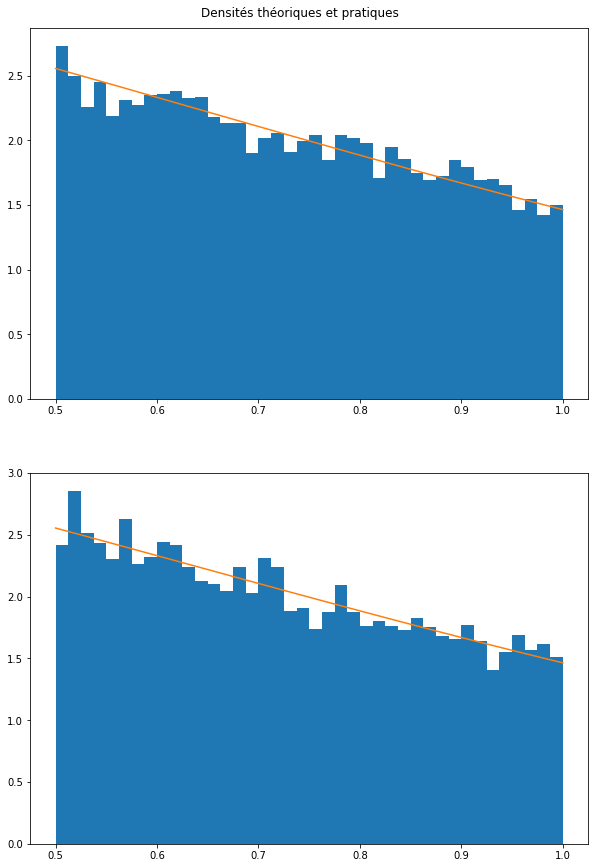

In [29]:
plot_Gibbs(Test, mu, Sigma, l, u)

Reproduction pour d quelconque des résultats du papier dans l'exemple 1 (Fernandez et al., 2007).

In [44]:
D = [2,3,5,10,15]
n = 10000
for d in D:
    mu = np.zeros(d)
    Sigma = np.linalg.inv(0.5*(np.ones(d).reshape((-1,1)) @ np.ones(d).reshape((1,-1)))+0.5*np.diag(np.ones(d)))
    l = 0.5*np.ones(d)
    u = np.ones(d)
    L = np.linalg.cholesky(Sigma)
    X_hist = SOV(n, mu, l, u, Sigma)
    Stat_SOV = []
    for n_ in range(n):
        u_app = u_tilde(X_hist[n_], u, L)
        l_app = l_tilde(X_hist[n_], l, L)
        m = 1
        for k_ in range(len(mu)):
            m *= norm.cdf(u_app[k_])-norm.cdf(l_app[k_])
        Stat_SOV.append(m)
    print("d = ", d, ". SOV: L'estimateur de la constante de normalisation est: ", np.mean(Stat_SOV)," +- ", 1.96*np.sqrt(np.var(Stat_SOV))/np.sqrt(n),".", sep ='')
    P0 = np.concatenate((0.7*np.ones(d), 0.4*np.ones(d)))
    res = fsolve(dpsi, P0, fprime = ddpsi, args = (l, u, L))
    print("d = ", d, ". exp(psi(x*;u*)): L'estimateur de la constante de normalisation est: ", np.exp(psi(res, l, u, L)), ".", sep ='')
    MET = []
    for n_ in range(n):
        MET.append(psi(np.concatenate((G(l, u, L, mu), res[d:])), l, u, L))
    MM = np.exp(MET)
    print("d = ", d, ". MET: L'estimateur de la constante de normalisation est: ", np.mean(MM)," +- ", 1.96*np.sqrt(np.var(MM))/np.sqrt(n),".", sep ='')
    print('\n')

d = 2. SOV: L'estimateur de la constante de normalisation est: 0.014909017093023533 +- 2.302886184458778e-05.
d = 2. exp(psi(x*;u*)): L'estimateur de la constante de normalisation est: 0.014933520883401236.
d = 2. MET: L'estimateur de la constante de normalisation est: 0.014895465063306338 +- 6.892054176192259e-07.
d = 3. SOV: L'estimateur de la constante de normalisation est: 0.0010803757602789099 +- 3.633599180667379e-06.
d = 3. exp(psi(x*;u*)): L'estimateur de la constante de normalisation est: 0.0010835081580523678.
d = 3. MET: L'estimateur de la constante de normalisation est: 0.001076903893787294 +- 1.419027029163212e-07.
d = 5. SOV: L'estimateur de la constante de normalisation est: 2.449526750875157e-06 +- 2.0555955829055005e-08.
d = 5. exp(psi(x*;u*)): L'estimateur de la constante de normalisation est: 2.483312430607983e-06.
d = 5. MET: L'estimateur de la constante de normalisation est: 2.444846161345086e-06 +- 9.126594892487461e-10.
d = 10. SOV: L'estimateur de la constante d

In [ ]:
#La haute proba d'acceptation est très intéressante pour simuler des lois, elle permet d'atteindre un temps minimal avant 
#d'obtenir un échantillon, c'est en particulier efficace quand d est grand et que donc la mesure de l'évènement de troncature 
#est très petit